<a href="https://colab.research.google.com/github/miladbahrami/Learning-Independent-Causal-Mechanisms/blob/master/LICM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [2]:
# Importing Libraries
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset, Dataset
import torch
import time
import os
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

In [3]:
# Constants
outdir = '.' #path to the output directory
optimizer_experts = 'adam' # optimization algorithm (options: sgd | adam)
optimizer_discriminator ='adam' # optimization algorithm (options: sgd | adam)
optimizer_initialize ='adam' # optimization algorithm (options: sgd | adam)
batch_size = 32 # input batch size for training
input_size = 784 # input size of data
epochs = 10 # number of epochs to train
epochs_init = 10 # number of epochs to initially train experts
no_cuda = False # enables CUDA training
seed = 11 # random seed
log_interval = 10 # how many batches to wait before logging training status
learning_rate_initialize = 1e-1 # size of expert learning rate
learning_rate_expert = 1e-3 #size of expert learning rate
learning_rate_discriminator =1e-3 # size of discriminator learning rate
name = '' #name of experiment
weight_decay = 0 # weight decay for optimizer
num_experts = 5 # number of experts
load_initialized_experts = False # whether to load already pre-trained experts
model_for_initialized_experts ='' # path to pre-trained experts
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
# Load dataset Original
transform_org = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_org
)

dataset_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_org
)

# Create Dataloader from orginal dataset
data_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=int(cuda), pin_memory=cuda)

100%|██████████| 9912422/9912422 [00:00<00:00, 77540730.32it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24295165.23it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24548725.15it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6237894.16it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



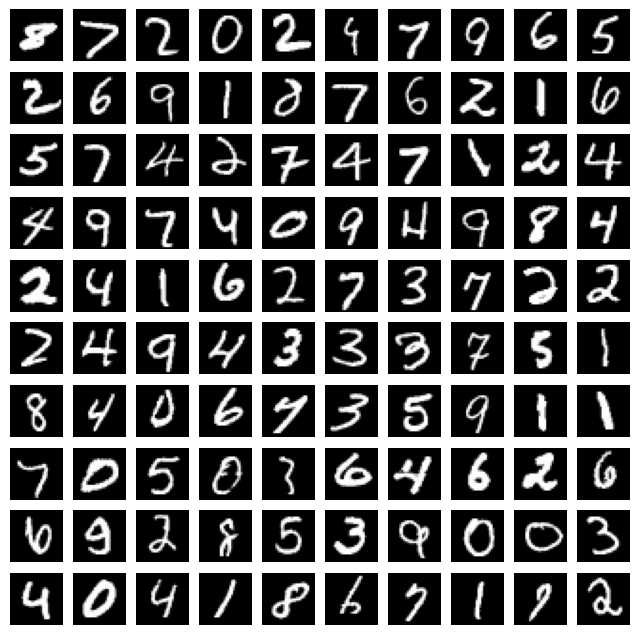

Train Size: 60000, Test Size: 10000


In [5]:
# Show Sample Data from Orginal Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Train and Test Dataset Size
print('Train Size: {}, Test Size: {}'.format(len(dataset_train),len(dataset_test)))

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [7]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [8]:
# Define transformations
transformations = [
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.affine(x ,0, (4, 0), 1, 0, 0)),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.affine(x ,0, (-4, 0), 1, 0, 0)),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.affine(x ,0, (0, 4), 1, 0, 0)),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.affine(x ,0, (0, -4), 1, 0, 0)),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.affine(x ,0, (4, 4), 1, 0, 0)),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.affine(x ,0, (-4, 4), 1, 0, 0)),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.affine(x ,0, (4, -4), 1, 0, 0)),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.affine(x ,0, (-4, -4), 1, 0, 0)),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        AddGaussianNoise(0., 0.25),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.invert(x)),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
]

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

# Divide dataset into equal parts
num_parts = len(transformations)
part_size = len(train_dataset) // num_parts
parts = []
# Apply transformations to each part
for i in range(num_parts):
    subset_i = Subset(train_dataset, list(range(i*part_size, (i+1)*part_size)))
    dataset_i = MyDataset(subset_i,transformations[i])
    parts.append(dataset_i)


# Combine the transformed parts
dataset_train_transformed = torch.utils.data.ConcatDataset(parts)
data_train_transformed = DataLoader(dataset_train_transformed, batch_size=batch_size, shuffle=True, num_workers=int(cuda), pin_memory=cuda)

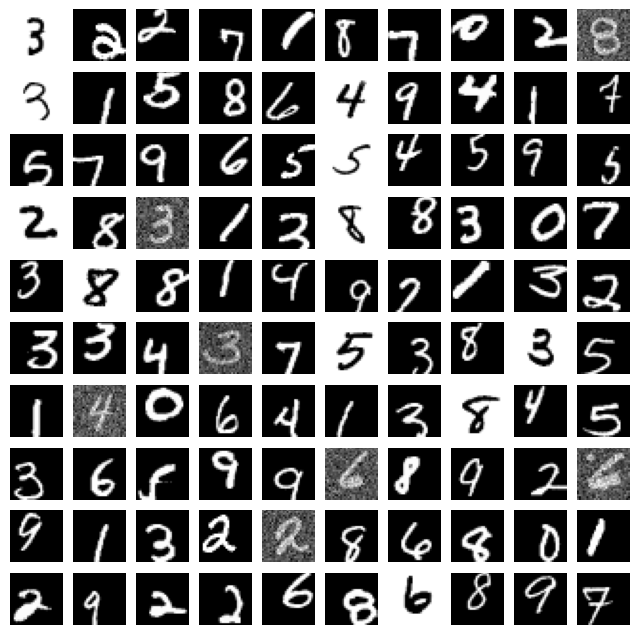

In [9]:
# Show Sample Data From Transformed Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train_transformed), size=(1,)).item()
    img, label = dataset_train_transformed[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Model**

In [10]:
import torch.nn as nn
import torch

In [11]:
# Random seed
torch.manual_seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed_all(seed)

# Name of The Experiment
timestamp = str(int(time.time()))
if name == '':
    name = 'n_exp_{}_bs_{}_lri_{}_lre_{}_lrd_{}_ei_{}_e_{}_oi_{}_oe_{}_oe_{}_{}'.format(
        num_experts, batch_size, learning_rate_initialize,
        learning_rate_expert, learning_rate_discriminator, epochs_init,
        epochs, optimizer_initialize, optimizer_experts, optimizer_discriminator,
        timestamp)
else:
    name = '{}_{}'.format(name, timestamp)

print('\nExperiment: {}\n'.format(name))

# Logging. To run: tensorboard --logdir <args.outdir>/logs
log_dir = os.path.join(outdir, 'logs')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
log_dir_exp = os.path.join(log_dir, name)
os.mkdir(log_dir_exp)
writer = SummaryWriter(log_dir=log_dir_exp)

# Directory for checkpoints
checkpt_dir = os.path.join(outdir, 'checkpoints')
if not os.path.exists(checkpt_dir):
    os.mkdir(checkpt_dir)



Experiment: n_exp_5_bs_32_lri_0.1_lre_0.001_lrd_0.001_ei_10_e_10_oi_adam_oe_adam_oe_adam_1688217902



In [12]:
class Expert(nn.Module):
    def __init__(self):
        super(Expert, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.elu1 = nn.ELU()

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.elu2 = nn.ELU()

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.elu3 = nn.ELU()

        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.elu4 = nn.ELU()

        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.elu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.elu4(x)

        x = self.conv5(x)
        x = self.sigmoid(x)

        return x

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.elu1 = nn.ELU()

        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.elu2 = nn.ELU()

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.elu3 = nn.ELU()

        self.pool1 = nn.AvgPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.elu4 = nn.ELU()

        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.elu5 = nn.ELU()

        self.pool2 = nn.AvgPool2d(kernel_size=2)

        self.conv6 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.elu6 = nn.ELU()

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.elu7 = nn.ELU()

        self.pool3 = nn.AvgPool2d(kernel_size=2)

        self.fc1 = nn.Linear(64 * 3 * 3, 1024)
        self.elu8 = nn.ELU()

        self.fc2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu1(x)

        x = self.conv2(x)
        x = self.elu2(x)

        x = self.conv3(x)
        x = self.elu3(x)

        x = self.pool1(x)

        x = self.conv4(x)
        x = self.elu4(x)

        x = self.conv5(x)
        x = self.elu5(x)

        x = self.pool2(x)

        x = self.conv6(x)
        x = self.elu6(x)

        x = self.conv7(x)
        x = self.elu7(x)

        x = self.pool3(x)

        x = x.view(-1, 64 * 3 * 3)
        # x = x.view(-1, x.size()[0])

        x = self.fc1(x)
        x = self.elu8(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [14]:
def initialize_expert(epochs, expert, i, optimizer, loss, data_train, writer):
    print("Initializing expert [{}] as identity on preturbed data".format(i+1))
    expert.train()
    for epoch in range(epochs):
        total_loss = 0
        n_samples = 0
        for batch in data_train:
            x_transformed, y = batch
            x_transformed = x_transformed.to(device)
            batch_size = x_transformed.size(0)
            n_samples += batch_size
            # x_transformed = x_transformed.view(x_transformed.size(0), -1).to(device)
            x_hat = expert(x_transformed)
            loss_rec = loss(x_hat, x_transformed)
            total_loss += loss_rec.item()*batch_size
            optimizer.zero_grad()
            loss_rec.backward()
            optimizer.step()

        # Loss
        mean_loss = total_loss/n_samples
        print("initialization epoch [{}] expert [{}] loss {:.4f}".format(epoch+1, i+1, mean_loss))
        writer.add_scalar('expert_{}_initialization_loss'.format(i+1), mean_loss, epoch+1)
        if mean_loss < 0.002:
            break

    torch.save(expert.state_dict(), checkpt_dir + '/{}_E_{}_init.pth'.format(name, i + 1))

In [15]:
def train_system(epoch, experts, discriminator, optimizers_E, optimizer_D, criterion, data_canonical, data_transformed, writer):
    discriminator.train()
    for i, expert in enumerate(experts):
        expert.train()

    # Labels for canonical vs transformed samples
    canonical_label = 1
    transformed_label = 0
    # Keep track of losses
    total_loss_D_canon = 0
    total_loss_D_transformed = 0
    loss_D_transformed = 0
    n_samples = 0
    total_loss_expert = [0 for i in range(len(experts))]
    total_samples_expert = [0 for i in range(len(experts))]
    expert_scores_D = [0 for i in range(len(experts))]
    expert_winning_samples_idx = [[] for i in range(len(experts))]
    canon_iter = iter(data_canonical)
    # Iterate through data
    for idx, batch in enumerate(data_transformed):
        x_transf, y_transf = batch
        x_transf = x_transf.to(device)
        x_canon, y_canon = next(canon_iter)
        x_canon = x_canon.to(device)
        # x_transf = torch.randn(x_canon.size()) # TODO temporary since do not have the preturbed data yet
        batch_size = x_canon.size(0)
        n_samples += batch_size
        # x_canon = x_canon.view(batch_size, -1).to(device)
        # x_transf = x_transf.view(batch_size, -1).to(device)

        # Train Discriminator on canonical distribution
        scores_canon = discriminator(x_canon)
        labels_canon = torch.full((batch_size,), canonical_label, device=device).unsqueeze(dim=1)
        loss_D_canon = criterion(scores_canon, labels_canon.float())
        total_loss_D_canon += loss_D_canon.item() * batch_size
        optimizer_D.zero_grad()
        loss_D_canon.backward()

        # Train Discriminator on experts output
        labels_transf = torch.full((batch_size,), transformed_label, device=device).unsqueeze(dim=1)
        loss_D_transformed = 0
        exp_outputs = []
        expert_scores = []
        for i, expert in enumerate(experts):
            exp_output = expert(x_transf)
            # exp_outputs.append(exp_output.view(batch_size, 1, input_size))
            exp_outputs.append(exp_output)
            exp_scores = discriminator(exp_output.detach())
            expert_scores.append(exp_scores)
            loss_D_transformed += criterion(exp_scores, labels_transf.float())
            # loss_D_transformed.backward()
            # optimizer_D.step()
        loss_D_transformed = loss_D_transformed / num_experts
        total_loss_D_transformed += loss_D_transformed.detach().item() * batch_size
        loss_D_transformed.backward()
        optimizer_D.step()

        # Train experts
        exp_outputs = torch.cat(exp_outputs, dim=1)
        expert_scores = torch.cat(expert_scores, dim=1)
        mask_winners = expert_scores.argmax(dim=1)

        # Update each expert on samples it won
        for i, expert in enumerate(experts):
            winning_indexes = mask_winners.eq(i).nonzero().squeeze(dim=-1)
            accrue = 0 if idx == 0 else 1
            # expert_winning_samples_idx[i] += (winning_indexes+accrue*n_samples).tolist()
            n_expert_samples = winning_indexes.size(0)
            if n_expert_samples > 0:
                total_samples_expert[i] += n_expert_samples
                exp_samples = exp_outputs[winning_indexes, i]
                exp_samples = torch.unsqueeze(exp_samples.clone(), 1)
                D_E_x_transf = discriminator(exp_samples)
                exp_labels = torch.full((n_expert_samples,), canonical_label,
                                    device=device).unsqueeze(dim=1)
                # breakpoint()
                loss_E = criterion(D_E_x_transf, exp_labels.float())
                # total_loss_expert[i] += loss_E.detach().item() * n_expert_samples
                optimizers_E[i].zero_grad()
                loss_E.backward(retain_graph=True) # TODO figure out why retain graph is necessary
                optimizers_E[i].step()
                # expert_scores_D[i] += D_E_x_transf.detach().squeeze().sum().item()

    # Logging
    mean_loss_D_generated = total_loss_D_transformed / n_samples
    mean_loss_D_canon = total_loss_D_canon / n_samples
    print("epoch [{}] loss_D_transformed {:.4f}".format(epoch + 1, mean_loss_D_generated))
    print("epoch [{}] loss_D_canon {:.4f}".format(epoch + 1, mean_loss_D_canon))
    writer.add_scalar('loss_D_canonical', mean_loss_D_canon, epoch + 1)
    writer.add_scalar('loss_D_transformed', mean_loss_D_generated, epoch + 1)
    for i in range(len(experts)):
        print("epoch [{}] expert [{}] n_samples {}".format(epoch + 1, i + 1, total_samples_expert[i]))
        writer.add_scalar('expert_{}_n_samples'.format(i + 1), total_samples_expert[i], epoch + 1)
        writer.add_text('expert_{}_winning_samples'.format(i + 1),
                           ":".join([str(j) for j in expert_winning_samples_idx[i]]), epoch + 1)
        if total_samples_expert[i]> 0:
            mean_loss_expert = total_loss_expert[i] / total_samples_expert[i]
            mean_expert_scores = expert_scores_D[i] / total_samples_expert[i]
            print("epoch [{}] expert [{}] loss {:.4f}".format(epoch + 1, i + 1, mean_loss_expert))
            print("epoch [{}] expert [{}] scores {:.4f}".format(epoch + 1, i + 1, mean_expert_scores))
            writer.add_scalar('expert_{}_loss'.format(i + 1), mean_loss_expert, epoch + 1)
            writer.add_scalar('expert_{}_scores'.format(i + 1), mean_expert_scores, epoch + 1)

In [16]:
def init_weights(model, path):
    pre_trained_dict = torch.load(path, map_location=lambda storage, loc: storage)
    for layer in pre_trained_dict.keys():
        model.state_dict()[layer].copy_(pre_trained_dict[layer])
    for param in model.parameters():
        param.requires_grad = True

In [17]:
# Model
experts = [Expert().to(device) for i in range(num_experts)]
discriminator = Discriminator().to(device)

In [18]:
# Losses
loss_initial = torch.nn.MSELoss(reduction='mean')
criterion = torch.nn.BCELoss(reduction='mean')

In [ ]:
# Initialize Experts as approximately Identity on Transformed Data
for i, expert in enumerate(experts):
    if load_initialized_experts:
        path = os.path.join(checkpt_dir,
                            model_for_initialized_experts + '_E_{}_init.pth'.format(i+1))
        init_weights(expert, path)
    else:
        if optimizer_initialize == 'adam':
            optimizer_E = torch.optim.Adam(expert.parameters(), lr=learning_rate_initialize,
                                                weight_decay=weight_decay)
        elif optimizer_initialize == 'sgd':
            optimizer_E = torch.optim.SGD(expert.parameters(), lr=learning_rate_initialize,
                                              weight_decay=weight_decay)
        else:
            raise NotImplementedError
        initialize_expert(epochs_init, expert, i, optimizer_E, loss_initial, data_train_transformed, writer)


Initializing expert [1] as identity on preturbed data
initialization epoch [1] expert [1] loss 0.7588
initialization epoch [2] expert [1] loss 0.7474
initialization epoch [3] expert [1] loss 0.7473
initialization epoch [4] expert [1] loss 0.7467
initialization epoch [5] expert [1] loss 0.7470
initialization epoch [6] expert [1] loss 0.7500
initialization epoch [7] expert [1] loss 0.7472
initialization epoch [8] expert [1] loss 0.7471
initialization epoch [9] expert [1] loss 0.7477
initialization epoch [10] expert [1] loss 0.7468
Initializing expert [2] as identity on preturbed data
initialization epoch [1] expert [2] loss 0.7561
initialization epoch [2] expert [2] loss 0.7476
initialization epoch [3] expert [2] loss 0.7473
initialization epoch [4] expert [2] loss 0.7470
initialization epoch [5] expert [2] loss 0.7473
initialization epoch [6] expert [2] loss 0.7471


In [ ]:
# Optimizers
optimizers_E = []
for i in range(num_experts):
    if optimizer_experts == 'adam':
        optimizer_E = torch.optim.Adam(experts[i].parameters(), lr=learning_rate_expert,
                                        weight_decay=weight_decay)
    elif optimizer_experts == 'sgd':
        optimizer_E = torch.optim.SGD(experts[i].parameters(), lr=learning_rate_expert,
                                      weight_decay=weight_decay)
    else:
        raise NotImplementedError
    optimizers_E.append(optimizer_E)

if optimizer_discriminator == 'adam':
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_discriminator,
                                    weight_decay=weight_decay)
elif optimizer_discriminator == 'sgd':
    optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=learning_rate_discriminator,
                                    weight_decay=weight_decay)

In [ ]:
print(discriminator)

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu2): ELU(alpha=1.0)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu3): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu4): ELU(alpha=1.0)
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu5): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu6): ELU(alpha=1.0)
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu7): ELU(alpha=1.0)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (elu8): ELU(alpha=1.0)
  (fc2): Lin

In [ ]:
# Training
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    train_system(epoch, experts, discriminator, optimizers_E, optimizer_D, criterion, data_train, data_train_transformed, writer)

    if epoch % log_interval == 0 or epoch == epochs-1:
        torch.save(discriminator.state_dict(), checkpt_dir + '/{}_D.pth'.format(name))
        for i in range(num_experts):
            torch.save(experts[i].state_dict(), checkpt_dir + '/{}_E_{}.pth'.format(name, i+1))

epoch [1] loss_D_transformed 0.0820
epoch [1] loss_D_canon 0.0076
epoch [1] expert [1] n_samples 47825
epoch [1] expert [1] loss 0.0000
epoch [1] expert [1] scores 0.0000
epoch [1] expert [2] n_samples 104
epoch [1] expert [2] loss 0.0000
epoch [1] expert [2] scores 0.0000
epoch [1] expert [3] n_samples 1044
epoch [1] expert [3] loss 0.0000
epoch [1] expert [3] scores 0.0000
epoch [1] expert [4] n_samples 11015
epoch [1] expert [4] loss 0.0000
epoch [1] expert [4] scores 0.0000
epoch [1] expert [5] n_samples 12
epoch [1] expert [5] loss 0.0000
epoch [1] expert [5] scores 0.0000
epoch [2] loss_D_transformed 0.0000
epoch [2] loss_D_canon 0.0000
epoch [2] expert [1] n_samples 60000
epoch [2] expert [1] loss 0.0000
epoch [2] expert [1] scores 0.0000
epoch [2] expert [2] n_samples 0
epoch [2] expert [3] n_samples 0
epoch [2] expert [4] n_samples 0
epoch [2] expert [5] n_samples 0
epoch [3] loss_D_transformed 0.0000
epoch [3] loss_D_canon 0.0000
epoch [3] expert [1] n_samples 60000
epoch [3]

KeyboardInterrupt: ignored